In [43]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,LabelEncoder,PowerTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
pd.set_option('display.max_columns',None)

# (4) **Model Selection**

In [2]:
df = pd.read_csv('final_data.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_bin,top_jobs,balance_bins,loan_default_risk,duration_min,is_long_cal,campaign_call,multiple_calls,contacted_before,pdays_cat,previous_camp_call,is_q2_calls,week,qtr,high_intensity_calls
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,never contacted,no,56-65,0,high positive,1,less than 5 minutes,0,1 call,0,False,never contacted,never contacted,1,week 1,Q2,0
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,never contacted,no,41-55,1,low positive,1,less than 3 minutes,0,1 call,0,False,never contacted,never contacted,1,week 1,Q2,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,never contacted,no,31-40,0,low positive,1,less than 2 minutes,0,1 call,0,False,never contacted,never contacted,1,week 1,Q2,0
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,never contacted,no,41-55,1,high positive,1,less than 2 minutes,0,1 call,0,False,never contacted,never contacted,1,week 1,Q2,0
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,never contacted,no,31-40,1,low positive,0,less than 4 minutes,0,1 call,0,False,never contacted,never contacted,1,week 1,Q2,0


In [3]:
cat_cols = ['job','marital','education','default','housing','loan','contact','month','day','month','poutcome','age_bin','top_jobs','balance_bins','loan_default_risk','duration_min','is_long_cal','campaign_call','multiple_calls','contacted_before','pdays_cat','previous_camp_call','is_q2_calls','week','qtr','high_intensity_calls']

In [4]:
# performing Ordinal Encoding 
df[cat_cols] = OrdinalEncoder().fit_transform(df[cat_cols])

In [5]:
# Encoding label
df['y'] = LabelEncoder().fit_transform(df['y'])

In [6]:
df['age'] = PowerTransformer(method='yeo-johnson').fit_transform(df[['age']])
df['balance'] = PowerTransformer(method='yeo-johnson').fit_transform(df[['balance']])

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_bin,top_jobs,balance_bins,loan_default_risk,duration_min,is_long_cal,campaign_call,multiple_calls,contacted_before,pdays_cat,previous_camp_call,is_q2_calls,week,qtr,high_intensity_calls
0,1.469224,4.0,1.0,2.0,0.0,0.413119,1.0,0.0,0.0,4.0,8.0,261,1,-1,0,1.0,0,3.0,0.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,0.0,1.0,0.0
1,0.426692,9.0,2.0,1.0,0.0,-0.411658,1.0,0.0,0.0,4.0,8.0,151,1,-1,0,1.0,0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,0.0,1.0,0.0
2,-0.711585,2.0,1.0,1.0,0.0,-0.431980,1.0,1.0,0.0,4.0,8.0,76,1,-1,0,1.0,0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,0.0,1.0,0.0
3,0.680096,1.0,1.0,1.0,0.0,0.196218,1.0,0.0,0.0,4.0,8.0,92,1,-1,0,1.0,0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,0.0,1.0,0.0
4,-0.711585,1.0,2.0,1.0,0.0,-0.432976,0.0,0.0,0.0,4.0,8.0,198,1,-1,0,1.0,0,1.0,1.0,2.0,0.0,3.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,0.0,1.0,0.0


In [8]:
x = df.drop('y',axis=1)
y = df['y']

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

(35555, 31)

## (a) Random forest Classifier 

In [10]:
rf = RandomForestClassifier(n_estimators=100,random_state=0).fit(x,y)

fi_df1 = pd.DataFrame({'features':x.columns,'rf_importance':rf.feature_importances_}).sort_values('rf_importance',ascending=False)
fi_df1

,features,rf_importance
11,duration,0.168653
5,balance,0.080936
20,duration_min,0.077881
0,age,0.077640
9,day,0.072069
10,month,0.058429
15,poutcome,0.052212
1,job,0.037177
13,pdays,0.033895
21,is_long_cal,0.030835


In [11]:
fi_df1.tail(10)

,features,rf_importance
14,previous,0.013616
17,top_jobs,0.011427
26,previous_camp_call,0.010162
25,pdays_cat,0.009744
23,multiple_calls,0.009297
7,loan,0.006631
8,contact,0.006474
24,contacted_before,0.005028
4,default,0.001555
30,high_intensity_calls,0.001523


## (b) Gradient Boosting Classifier

In [12]:
gb = GradientBoostingClassifier(n_estimators=100,random_state=0).fit(x,y)

fi_df2 = pd.DataFrame({'features':x.columns,'gb_importance':gb.feature_importances_}).sort_values('gb_importance',ascending=False)
fi_df2

,features,gb_importance
11,duration,0.483361
15,poutcome,0.202197
10,month,0.096368
19,loan_default_risk,0.067430
13,pdays,0.042178
0,age,0.033885
27,is_q2_calls,0.021388
9,day,0.013019
29,qtr,0.007002
5,balance,0.006903


In [13]:
fi_df2.tail(10)

,features,gb_importance
26,previous_camp_call,0.000538
17,top_jobs,0.000485
18,balance_bins,0.000243
21,is_long_cal,0.000133
20,duration_min,0.000126
4,default,0.000000
7,loan,0.000000
22,campaign_call,0.000000
24,contacted_before,0.000000
30,high_intensity_calls,0.000000


## (c) Shap values

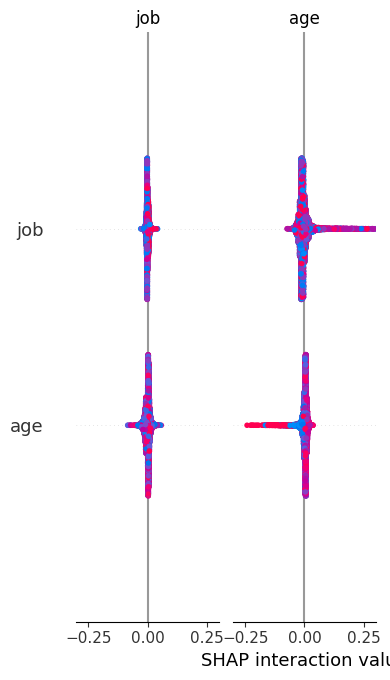

In [ ]:
rf = RandomForestClassifier(n_estimators=100,random_state=0)
rf.fit(x_train,y_train)

explainer = shap.TreeExplainer(rf)
shap_values = explainer(x_test,check_additivity=False)





In [28]:
np.abs((shap_values.values))

array([[[3.48699940e-03, 3.48699940e-03],
        [3.47760188e-03, 3.47760188e-03],
        [6.41228344e-03, 6.41228344e-03],
        ...,
        [2.19691660e-02, 2.19691660e-02],
        [5.79658445e-03, 5.79658445e-03],
        [1.38863437e-05, 1.38863437e-05]],

       [[7.38994012e-02, 7.38994012e-02],
        [1.12985757e-02, 1.12985757e-02],
        [4.45984545e-03, 4.45984545e-03],
        ...,
        [4.40877552e-03, 4.40877552e-03],
        [1.35522717e-03, 1.35522717e-03],
        [3.14705819e-05, 3.14705819e-05]],

       [[9.83961624e-03, 9.83961624e-03],
        [1.34301321e-03, 1.34301321e-03],
        [4.36129713e-03, 4.36129713e-03],
        ...,
        [2.66975400e-03, 2.66975400e-03],
        [5.47269381e-03, 5.47269381e-03],
        [4.20320787e-04, 4.20320787e-04]],

       ...,

       [[9.44205923e-03, 9.44205923e-03],
        [1.16461712e-02, 1.16461712e-02],
        [2.05430783e-03, 2.05430783e-03],
        ...,
        [4.07113718e-02, 4.07113718e-02],
     

In [38]:
fi_df3 = pd.DataFrame({'features':x.columns,'Shap_Importance':np.abs((shap_values.values).mean(axis=0))[:,0]}).sort_values(by='Shap_Importance',ascending=False)
fi_df3

,features,Shap_Importance
10,month,0.004857
15,poutcome,0.003646
9,day,0.003275
27,is_q2_calls,0.002976
13,pdays,0.001915
11,duration,0.001802
19,loan_default_risk,0.001652
21,is_long_cal,0.001416
29,qtr,0.001284
0,age,0.001148


In [37]:
pi = permutation_importance(estimator=rf,X=x_test,y=y_test,n_repeats=10,random_state=0,n_jobs=-1,scoring='roc_auc')

fi_df4 = pd.DataFrame({'features':x.columns,'Permutation_Importance':pi.importances_mean}).sort_values(by='Permutation_Importance',ascending=False)
fi_df4


,features,Permutation_Importance
11,duration,0.045682
27,is_q2_calls,0.020347
10,month,0.018234
20,duration_min,0.015272
9,day,0.013306
29,qtr,0.012522
15,poutcome,0.009042
13,pdays,0.006857
28,week,0.006010
0,age,0.005166


In [34]:
rfe = RFE(estimator=rf,n_features_to_select=x.shape[1]).fit(x,y)

features = x.columns[rfe.support_]
Importance = rfe.estimator_.feature_importances_

fi_df5 = pd.DataFrame({'features':features,'rfe_importance':Importance}).sort_values(by='rfe_importance',ascending=False)
fi_df5

,features,rfe_importance
11,duration,0.168653
5,balance,0.080936
20,duration_min,0.077881
0,age,0.077640
9,day,0.072069
10,month,0.058429
15,poutcome,0.052212
1,job,0.037177
13,pdays,0.033895
21,is_long_cal,0.030835


In [39]:
merged_df =fi_df1.merge(fi_df2,on='features').merge(fi_df3,on='features').merge(fi_df4,on='features').merge(fi_df5,on='features').set_index('features')
merged_df

,rf_importance,gb_importance,Shap_Importance,Permutation_Importance,rfe_importance
features,,,,,
duration,0.168653,0.483361,0.001802,0.045682,0.168653
balance,0.080936,0.006903,0.001049,-0.000065,0.080936
duration_min,0.077881,0.000126,0.000168,0.015272,0.077881
age,0.077640,0.033885,0.001148,0.005166,0.077640
day,0.072069,0.013019,0.003275,0.013306,0.072069
month,0.058429,0.096368,0.004857,0.018234,0.058429
poutcome,0.052212,0.202197,0.003646,0.009042,0.052212
job,0.037177,0.000958,0.000132,0.000783,0.037177
pdays,0.033895,0.042178,0.001915,0.006857,0.033895


In [40]:
final_df = merged_df.divide(merged_df.sum(axis=0),axis=1)
final_df

,rf_importance,gb_importance,Shap_Importance,Permutation_Importance,rfe_importance
features,,,,,
duration,0.168653,0.483361,0.057886,0.264870,0.168653
balance,0.080936,0.006903,0.033711,-0.000379,0.080936
duration_min,0.077881,0.000126,0.005411,0.088550,0.077881
age,0.077640,0.033885,0.036891,0.029955,0.077640
day,0.072069,0.013019,0.105209,0.077150,0.072069
month,0.058429,0.096368,0.156065,0.105723,0.058429
poutcome,0.052212,0.202197,0.117134,0.052428,0.052212
job,0.037177,0.000958,0.004257,0.004539,0.037177
pdays,0.033895,0.042178,0.061532,0.039758,0.033895


In [41]:
final_df = final_df.mean(axis=1).sort_values(ascending=False)
final_df

features
duration                0.228685
poutcome                0.095237
month                   0.095003
day                     0.067903
is_q2_calls             0.052945
age                     0.051202
duration_min            0.049970
pdays                   0.042252
balance                 0.040421
loan_default_risk       0.036916
qtr                     0.033638
is_long_cal             0.026856
week                    0.021778
job                     0.016822
previous                0.014317
age_bin                 0.013714
housing                 0.011950
balance_bins            0.011774
previous_camp_call      0.011673
marital                 0.011244
campaign                0.010981
pdays_cat               0.010000
education               0.009295
contacted_before        0.008908
campaign_call           0.008301
top_jobs                0.004740
contact                 0.004503
multiple_calls          0.004073
loan                    0.003602
high_intensity_calls    0.000728
d

In [42]:
cumsum_df = pd.DataFrame({'features':final_df.index,'Importance':final_df.values}).set_index('features')
cumsum_df

,Importance
features,
duration,0.228685
poutcome,0.095237
month,0.095003
day,0.067903
is_q2_calls,0.052945
age,0.051202
duration_min,0.049970
pdays,0.042252
balance,0.040421


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 [Text(0, 0, 'duration'),
  Text(1, 0, 'poutcome'),
  Text(2, 0, 'month'),
  Text(3, 0, 'day'),
  Text(4, 0, 'is_q2_calls'),
  Text(5, 0, 'age'),
  Text(6, 0, 'duration_min'),
  Text(7, 0, 'pdays'),
  Text(8, 0, 'balance'),
  Text(9, 0, 'loan_default_risk'),
  Text(10, 0, 'qtr'),
  Text(11, 0, 'is_long_cal'),
  Text(12, 0, 'week'),
  Text(13, 0, 'job'),
  Text(14, 0, 'previous'),
  Text(15, 0, 'age_bin'),
  Text(16, 0, 'housing'),
  Text(17, 0, 'balance_bins'),
  Text(18, 0, 'previous_camp_call'),
  Text(19, 0, 'marital'),
  Text(20, 0, 'campaign'),
  Text(21, 0, 'pdays_cat'),
  Text(22, 0, 'education'),
  Text(23, 0, 'contacted_before'),
  Text(24, 0, 'campaign_call'),
  Text(25, 0, 'top_jobs'),
  Text(26, 0, 'contact'),
  Text(27, 0, 'multiple_calls'),
  Text(28, 0, 'loan'),
  Text(29, 0, 'high_intensity_calls

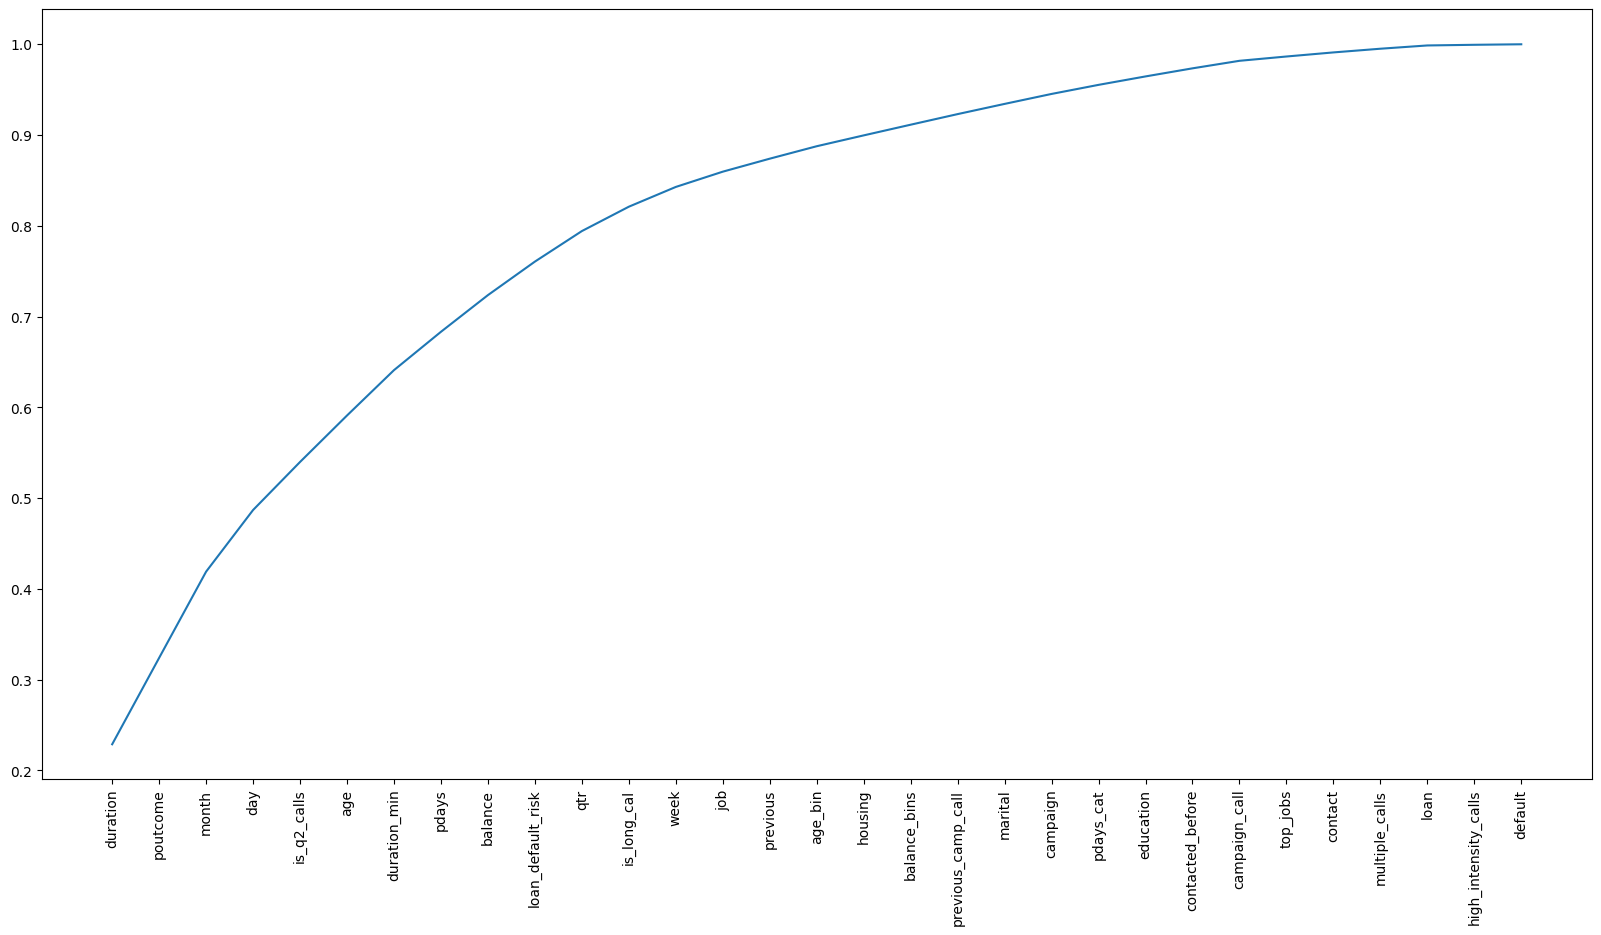

In [44]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(cumsum_df['Importance']))
plt.xticks(rotation=90)

In [45]:
col_to_drop = cumsum_df.tail(13).index

In [46]:
col_to_drop

Index(['previous_camp_call', 'marital', 'campaign', 'pdays_cat', 'education',
       'contacted_before', 'campaign_call', 'top_jobs', 'contact',
       'multiple_calls', 'loan', 'high_intensity_calls', 'default'],
      dtype='object', name='features')

In [48]:
cv1 = cross_val_score(estimator=rf,X=x,y=y,cv=5,scoring='roc_auc',n_jobs=-1)
print(f'Cross_val roc_auc score with full features: {cv1.mean()}')

Cross_val roc_auc score with full features: 0.5735243053002899


In [49]:
cv2 = cross_val_score(estimator=rf,X=x.drop(['previous_camp_call','marital','campaign','pdays_cat','education','contacted_before','campaign_call','top_jobs','contact','multiple_calls','loan','high_intensity_calls','default'],axis=1),y=y,cv=5,scoring='roc_auc',n_jobs=-1)
print(f'Cross_val roc_auc score with selected features: {cv2.mean()}')

Cross_val roc_auc score with selected features: 0.5383263231249643


## Even After reducing 13 columns , the roc_auc score didn't decreased much. I will remove these columns. Although the score is very low

In [50]:
df = df.drop(['previous_camp_call','marital','campaign','pdays_cat','education','contacted_before','campaign_call','top_jobs','contact','multiple_calls','loan','high_intensity_calls','default'],axis=1)

In [51]:
df.to_csv('feature_selected_data.csv')